En este notebook, se procesan y analizan los resultados obtenidos

In [1]:
import os
import pickle

from ast import literal_eval
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec, FastText
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures

EMBEDDING = 'word2vec'  # valores posibles: 'lda', 'word2vec', 'fasttext'

NUM_TOPICS=120
topics = range(0, NUM_TOPICS, 1)

TEXT_FILE_READ = 'docs/reddit_data_hate_speech_' + EMBEDDING + '.csv'
HATE_WORDS = 'docs/palabras_odio.csv'
TOPIC_TEST_FOLDER = 'docs/test/hstopic/'

os.makedirs(TOPIC_TEST_FOLDER, exist_ok=True)
np.random.seed(42)

In [2]:
reddit = pd.read_csv(TEXT_FILE_READ)
hate_words = pd.read_csv(HATE_WORDS)

Definimos las funciones que vamos a usar

In [3]:
def get_counts_words(reddit):
    words_hate_speech = []

    for sent in reddit['body_preprocessing']:
        for word in str(sent).split():
            words_hate_speech.append(word)
    return Counter(words_hate_speech)

In [4]:
def get_pmi_por_cluster(selected_cluster, hate_speech, minimum_word_occurrences=10):
    reddit_words_hate = reddit[(reddit["cluster"] == str([selected_cluster])) &
                      (reddit["hate_speech"]=="si")]['lemma_tokens'].apply(literal_eval)
    reddit_words_counter_hate = Counter(sum(list(reddit_words_hate),[]))
    
    word_pmis = {}

    total_msgs = len(reddit['body_preprocessing']) - reddit['body_preprocessing'].isnull().value_counts()[1]

    for word in reddit_words_counter_hate:
    
        try:
            p_non_hate_msg_without_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
            p_hate_msg_without_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
            p_non_hate_msg_with_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
            p_hate_msg_with_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
        except:
            continue

        if (p_non_hate_msg_with_word + p_hate_msg_with_word)*total_msgs >= minimum_word_occurrences:
            
            if hate_speech == "si":
                word_pmis[word] = np.log2(p_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
            elif hate_speech == "no":
                word_pmis[word] = np.log2(p_non_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
            else:
                raise ValueError("Se pasó un argumento desconocido para obtener pmi")

    return word_pmis

In [5]:
#type_analysis: el tipo de análisis hace referencia a como se analizan las palabras en cada cluster. 0 es por frecuencia; 1 es por información mutua.
def plot_word_cloud(topic_list, type_analysis='freq'):
    data = {'topic': [], 'score_hate_speech': [], 'score_not_hate_speech': [], 'comms_num_hate_speech': [], 'comms_num_not_hate_speech': []}
    df_marks = pd.DataFrame(data)
    
    for topic in topic_list:
        reddit_hate_speech = reddit.loc[(reddit["cluster"] == str([topic])) & (reddit["hate_speech"] == "si")]
        reddit_not_hate_speech = reddit.loc[(reddit["cluster"] == str([topic])) & (reddit["hate_speech"] == "no")]

        reddit_hate_speech.to_csv(TOPIC_TEST_FOLDER + str(topic) + '_hp.csv')
        reddit_not_hate_speech.to_csv(TOPIC_TEST_FOLDER + str(topic) + '_nhp.csv')

        if len(reddit_hate_speech) > 0 or len(reddit_not_hate_speech) > 0:
            types = ['Hate Speech','Not Hate Speech']
            score = [reddit_hate_speech['score'].mean(),reddit_not_hate_speech['score'].mean()]
            num_comments = [reddit_hate_speech['comms_num'].mean(),reddit_not_hate_speech['comms_num'].mean()]
            New_Colors = ['red','blue']

            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(30,5))
            fig.suptitle('Tópico ' + str(topic))

            if len(reddit_hate_speech) > 0:
                if type_analysis == 'freq':
                    ax1.imshow(WordCloud(random_state=1, max_words=20, background_color='black', colormap='Set2', collocations=False, stopwords=STOPWORDS)
                               .fit_words(get_counts_words(reddit_hate_speech)))
                elif type_analysis == 'pmi':
                    words = get_pmi_por_cluster(topic, "si")
                    if len(words) > 0:
                        ax1.imshow(WordCloud(random_state=1, max_words=20, background_color='black', colormap='Set2', collocations=False, stopwords=STOPWORDS)
                               .fit_words(words))

                else:
                    raise ValueError('Se pasó una configuración de nube de palabras no definida')

            ax1.axis("off")
            ax1.set_title('Palabras Hate Speech')

            if len(reddit_not_hate_speech) > 0:
                if type_analysis == 'freq':
                    ax2.imshow(WordCloud(random_state=1, max_words=20, background_color='navy', colormap='rainbow', collocations=False, stopwords=STOPWORDS)
                           .fit_words(get_counts_words(reddit_not_hate_speech)))
                elif type_analysis == 'pmi':
                    words = get_pmi_por_cluster(topic, "no")
                    if len(words) > 0:
                        ax2.imshow(WordCloud(random_state=1, max_words=20, background_color='navy', colormap='rainbow', collocations=False, stopwords=STOPWORDS)
                               .fit_words(words))
                else:
                    raise ValueError('Se pasó una configuración de nube de palabras no definida')

            ax2.axis("off")
            ax2.set_title('Palabras Not Hate Speech')

            ax3.bar(types, score, color=New_Colors)
            ax3.set_title('Puntaje promedio')
            ax3.grid(True)

            ax4.bar(types, num_comments, color=New_Colors)
            ax4.set_title('Números de comentarios promedio')
            ax4.grid(True)

            ax5.bar(types, [len(reddit_hate_speech), len(reddit_not_hate_speech)], color=New_Colors)
            ax5.set_title('Números de comentarios Clasificador por odio y no odio')
            ax5.grid(True)

            new_row = {'topic':topic, 'score_hate_speech':score[0], 'score_not_hate_speech':score[1], 'comms_num_hate_speech':num_comments[0], 'comms_num_not_hate_speech':num_comments[1]}
            df_marks = df_marks.append(new_row, ignore_index=True)
        else:
            print('No tiene palabras')
    
    return df_marks

In [6]:
def calcular_distancias(topic_list, model, kmeans):
    distances = {}
    
    for word in pd.Series([hate_words['hateval_rf'], hate_words['hateval_nb'],
                    hate_words['detoxis_rf'], hate_words['detoxis_nb'],
                    hate_words['meoffendmex_rf'], hate_words['meoffendmex_nb']]).iloc[0]:
        word_distance_per_topic = []
        for topic in topic_list:
            try:
                word_distance_per_topic.append(np.linalg.norm(model.wv.get_vector(word) - kmeans.cluster_centers_[topic]))
            except KeyError:
                word_distance_per_topic.append(np.inf)
        distances[word] = word_distance_per_topic
    
    return distances

In [7]:
def ver_palabras_asociadas(palabras_asociadas, embedding, clustering_model):
    for palabra_asociada in palabras_asociadas:
        print('Palabra: {}'.format(palabra_asociada))
        print('Clúster: {}'.format(clustering_model.predict(np.array([embedding.wv.get_vector(palabra_asociada)], dtype=float))))
        print('Términos cercanos: {} \n'.format(embedding.wv.most_similar(palabra_asociada)))

In [8]:
# le quitamos los paréntesis a las listas con el num de cluster
reddit['cluster_n'] = reddit['cluster'].apply(lambda x: literal_eval(x)[0])

# transformamos en la columna hate speech: si -> 1; no -> 0
reddit['hate_speech_bool'] = reddit['hate_speech'].apply(lambda x: 1 if x == 'si' else 0)

## Análisis de los resultados obtenidos

1. Número de mensajes por tópico

Se cuenta con un total de 120 tópicos, cuyos 27791 comentarios se distribuyen de la siguiente manera:

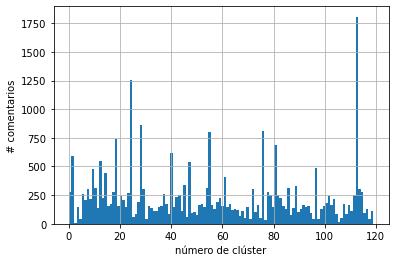

In [9]:
reddit['cluster_n'].hist(bins=NUM_TOPICS)
plt.xlabel('número de clúster')
plt.ylabel('# comentarios')
plt.show()

Vemos los clústers que más comentarios tienen

In [10]:
reddit.groupby(['cluster_n'])['comms_num'].count().sort_values(ascending=False)

cluster_n
113    1807
24     1252
28      860
76      812
55      801
       ... 
4        41
98       39
77       30
106      15
2         9
Name: comms_num, Length: 120, dtype: int64

De entre ellos, vemos cómo se distribuye la detección de comentarios de odio.

In [29]:
# cantidad de comentarios clasificados como odio
len(reddit[reddit['hate_speech'] == 'si'])

2075

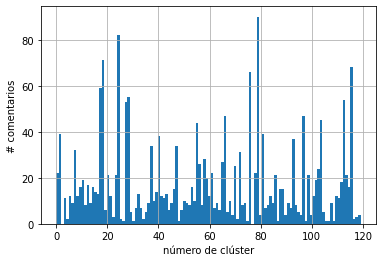

In [11]:
reddit[reddit['hate_speech'] == 'si']['cluster_n'].hist(bins=NUM_TOPICS)
plt.xlabel('número de clúster')
plt.ylabel('# comentarios')
plt.show()

2. Vemos el % de comentarios de odio predichos en cada cluster

In [31]:
clusters_by_positive_prop = reddit.groupby(['cluster_n'])['hate_speech_bool'].mean().sort_values(ascending=False)
clusters_by_positive_prop[:10]

cluster_n
116    0.731183
66     0.391667
79     0.361446
27     0.277487
93     0.246667
46     0.238095
17     0.215328
65     0.214286
104    0.205479
39     0.168675
Name: hate_speech_bool, dtype: float64

3. Vemos el % de comentarios de odio que se predijeron según cada flair

In [13]:
reddit.groupby(['flair'])['hate_speech_bool'].mean().sort_values(ascending=False)

flair
Historia🇦🇷         0.114650
Policiales🚨        0.101064
Política🏛️         0.095777
Meet-up❗           0.093750
Video📽️            0.092094
Noticia📰           0.090787
Coronavirus😷       0.083333
IAMA🙋              0.073950
Meme💩              0.072362
Serio💭             0.072256
Economía📈          0.070326
Tweet :tweet:      0.070270
PSA👀               0.070175
Cultura🎭           0.067582
Humor:snoo_joy:    0.066962
Artentina🎨         0.063395
ArgenFoto📸         0.061856
Deportes⚽          0.060606
Sticky 📌           0.060416
Ciencia 🧬          0.056452
Discusion🧐         0.056372
Exchange🗺️         0.029126
Name: hate_speech_bool, dtype: float64

4. Vemos la correlación entre el puntaje recibido y la detección como de odio

In [14]:
reddit[['score', 'hate_speech_bool']].corr()

,score,hate_speech_bool
score,1.000000,-0.001503
hate_speech_bool,-0.001503,1.000000


Se aprecia que, considerando todos los mensajes y clústers, no existe una correlación lineal entre el puntaje obtenido y la detección del mensaje como de odio.

In [45]:
reddit[reddit['cluster_n'] == 79][['score', 'hate_speech_bool']].corr()

,score,hate_speech_bool
score,1.00000,-0.02568
hate_speech_bool,-0.02568,1.00000


Respecto al clúster donde se predijo una mayor proporción de mensajes de odio, la correlación es ligeramente mayor, pero de todas formas sigue siendo baja.

In [15]:
reddit[['comms_num', 'hate_speech_bool']].corr()

,comms_num,hate_speech_bool
comms_num,1.000000,-0.016838
hate_speech_bool,-0.016838,1.000000


In [46]:
reddit[reddit['cluster_n'] == 79][['comms_num', 'hate_speech_bool']].corr()

,comms_num,hate_speech_bool
comms_num,1.000000,-0.150807
hate_speech_bool,-0.150807,1.000000


Tampoco se observa una correlación entre la detección de odio y la cantidad de comentarios.

5. Tomamos los 5 clusters en donde más se predijo discurso de odio y vemos los tópicos que allí se hablan

En base a los mensajes detectados por el modelo como odio o no odio, visualizamos las palabras más frecuentes, el número de respuestas que recibió en promedio ese comentario, y el número de comentarios que el clasificador detectó:

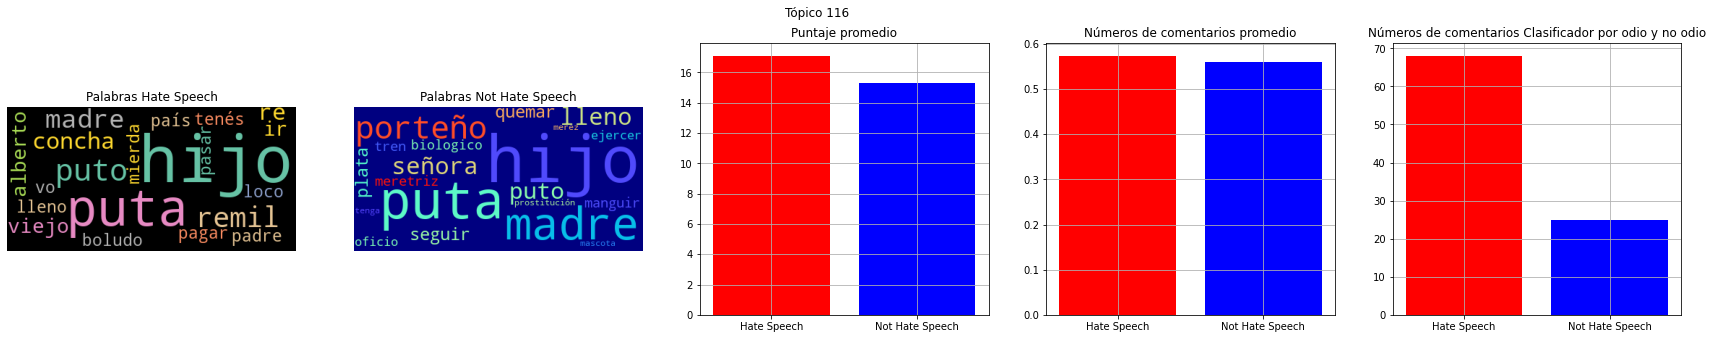

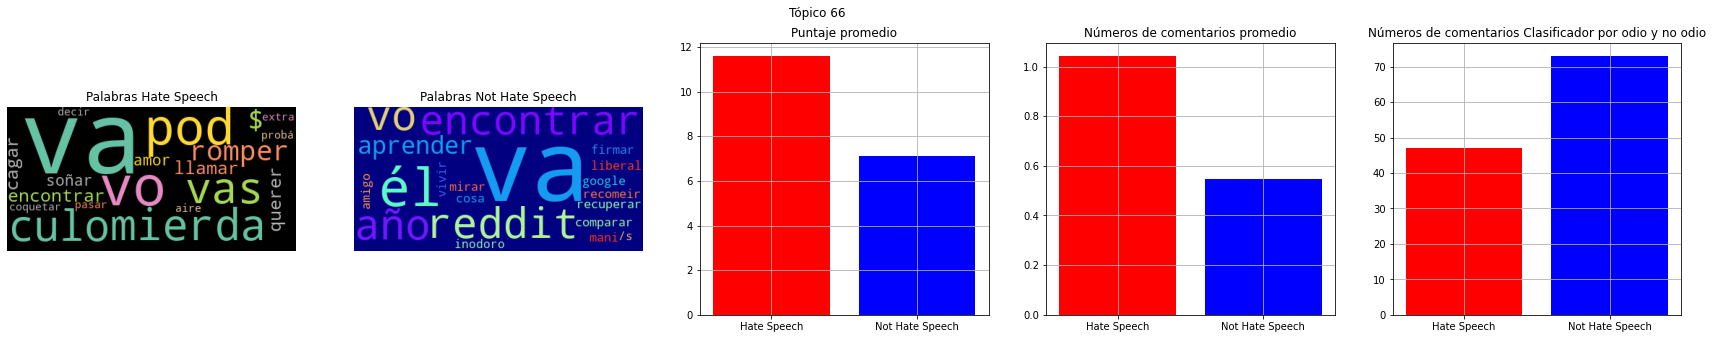

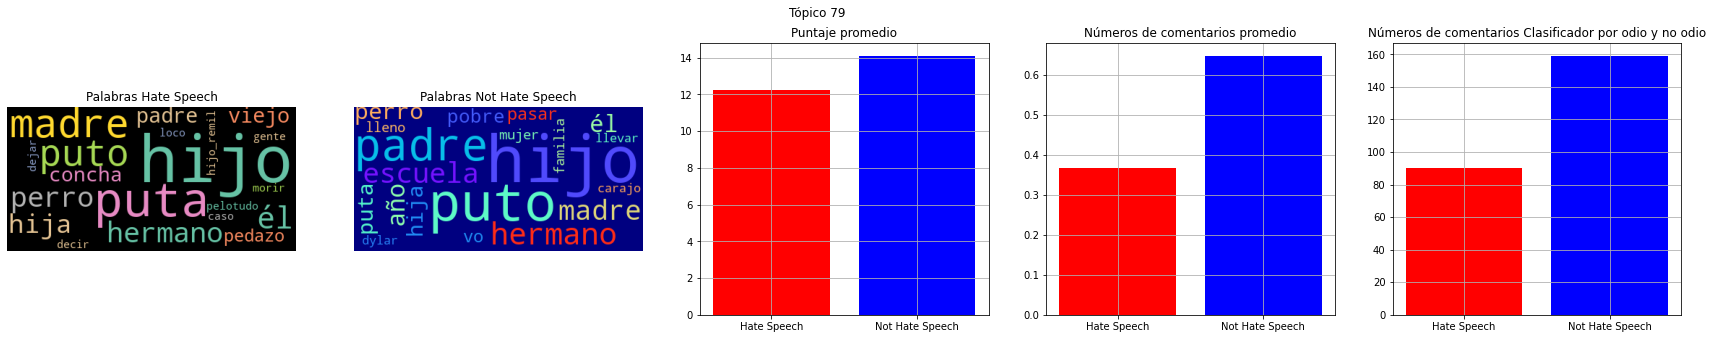

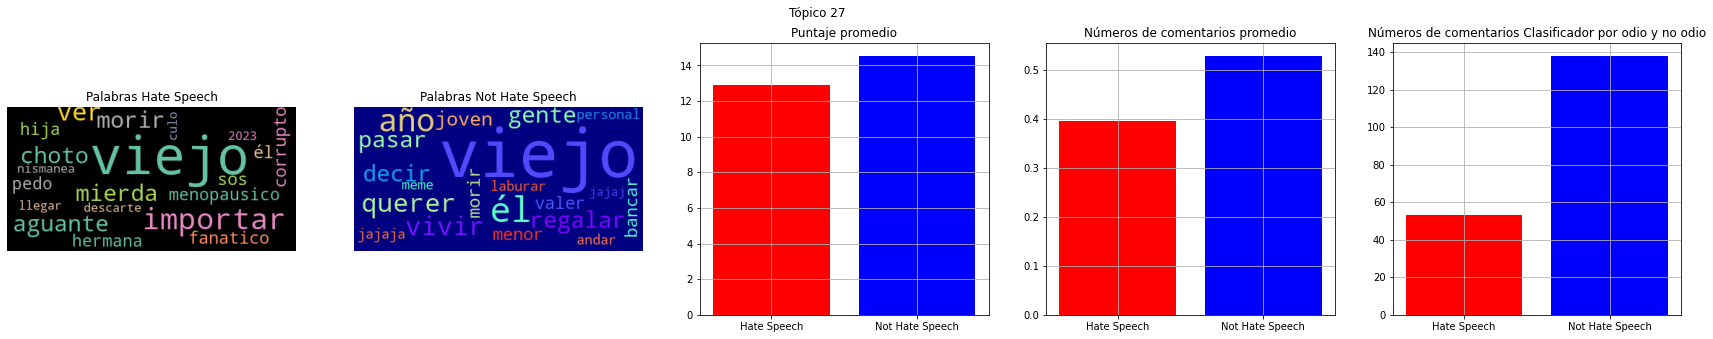

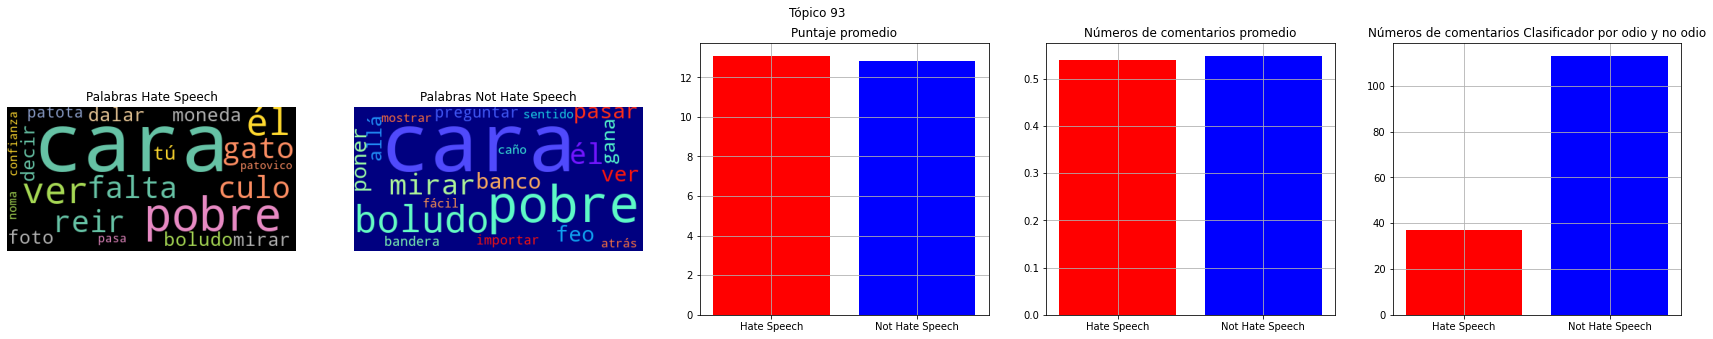

In [16]:
df_marks = plot_word_cloud([clusters_by_positive_prop.index[i] for i in range(5)], "freq")

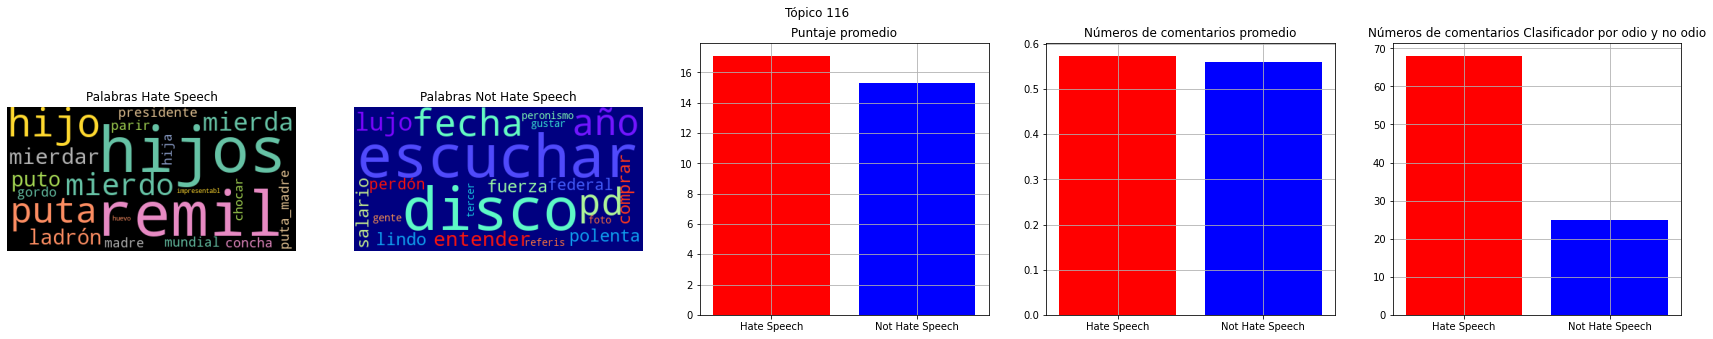

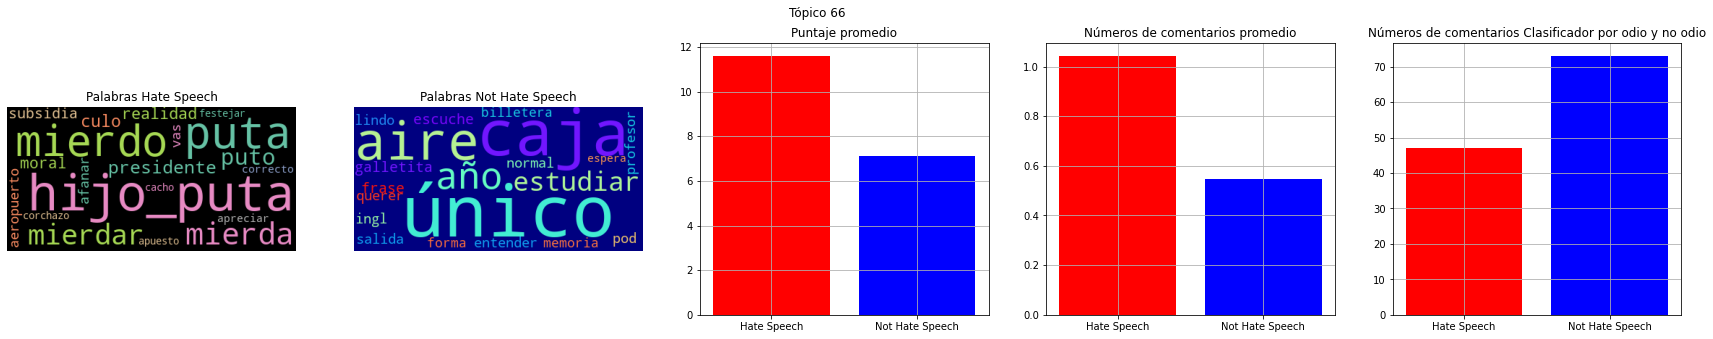

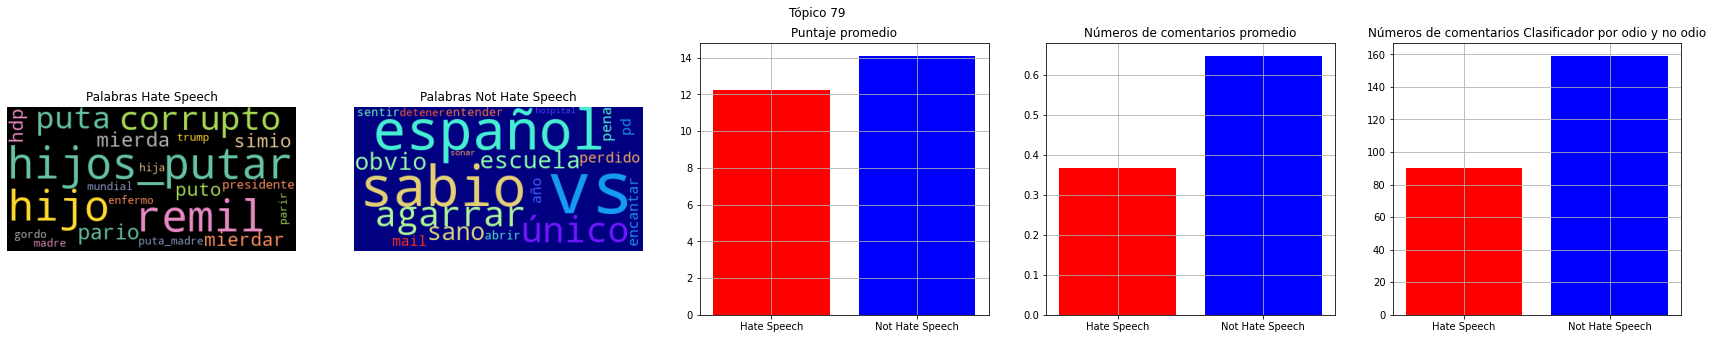

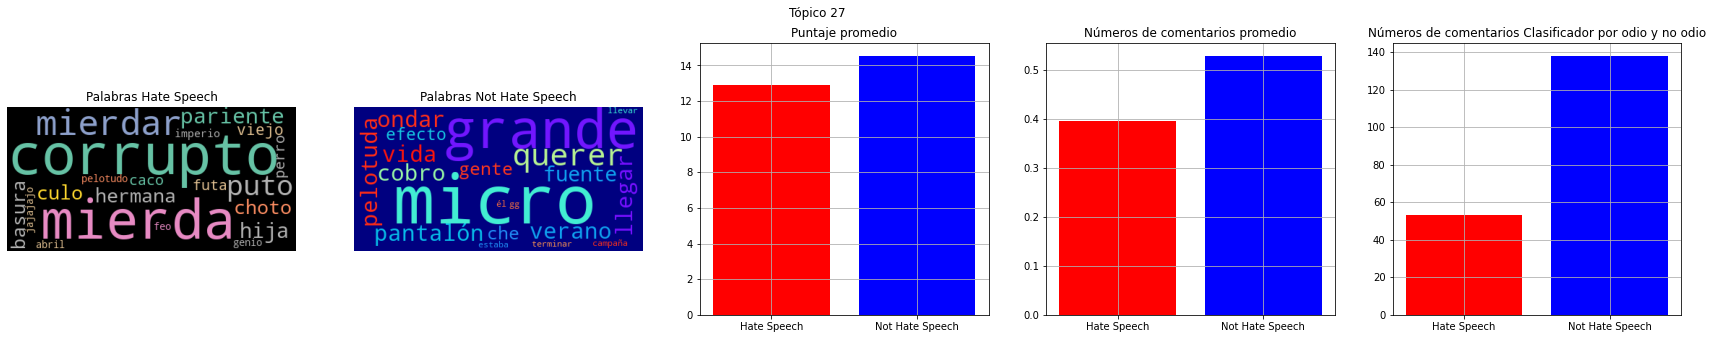

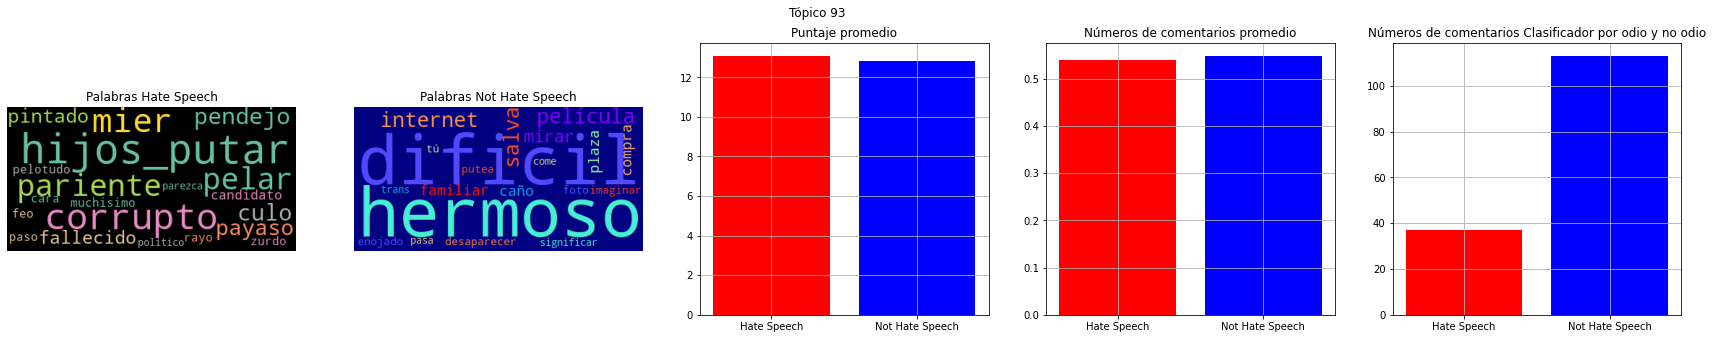

In [17]:
df_marks = plot_word_cloud([clusters_by_positive_prop.index[i] for i in range(5)], "pmi")

Se observa que con información mutua distingue mucho mejor las palabras de odio / agresión que la frecuencia.

6. Análisis sobre clusters de genero y de soberania

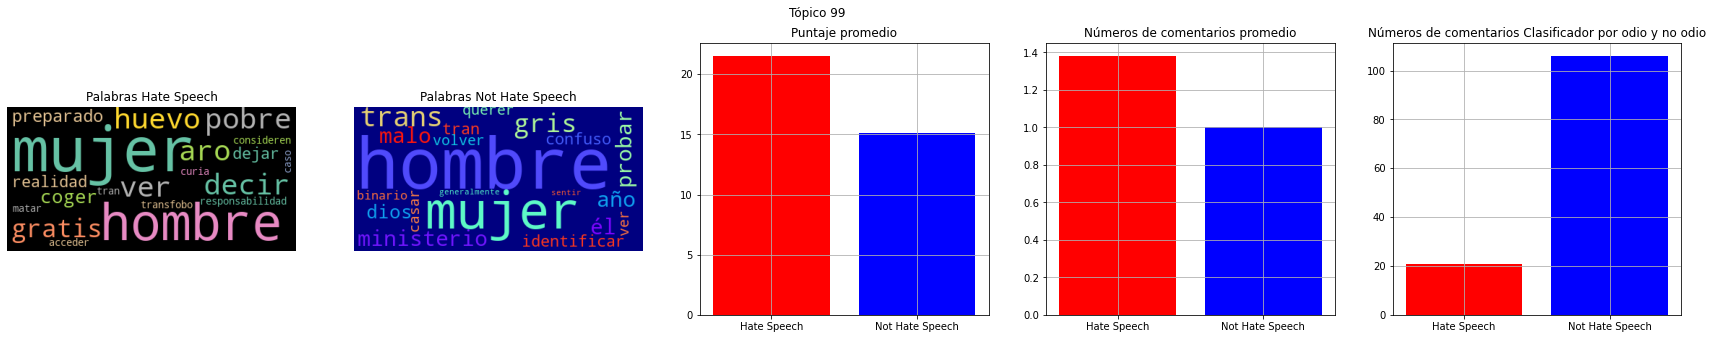

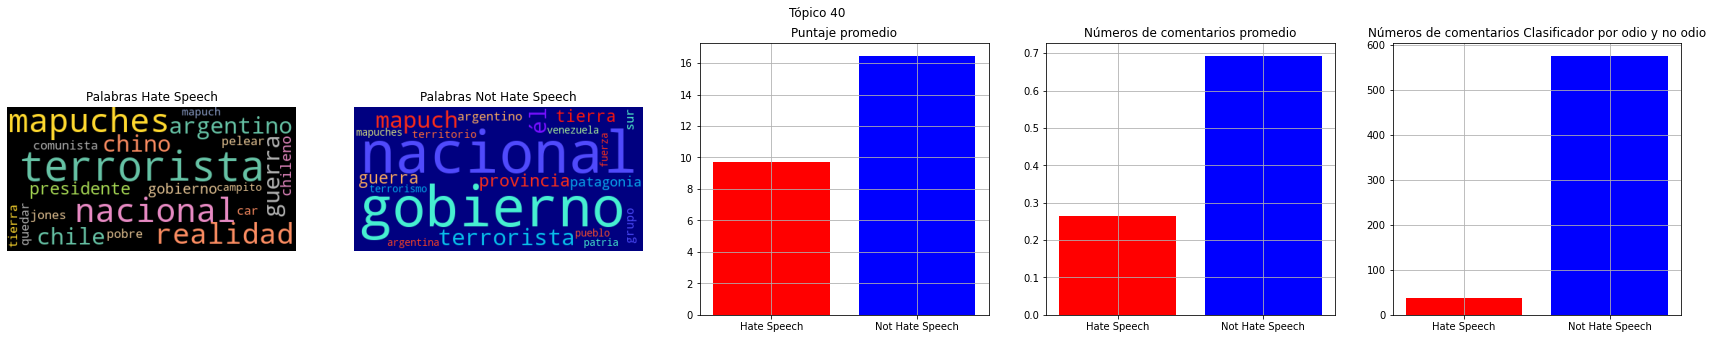

In [18]:
# algunos tópicos interesantes: [8, 13, 14, 18, 23, 44, 53, 59, 61, 64, 72, 73, 87, 94, 98, 99, 100, 104, 114]
# topicos hand-picked = [8 (economía), 18 (política), 99 (mujeres), 94 (leyes), 73]

#df_marks = plot_word_cloud(np.arange(0, 119, 1), "freq")
df_marks = plot_word_cloud([99,40], "freq")

Vemos los resultados del modelo en el dataset etiquetado manualmente

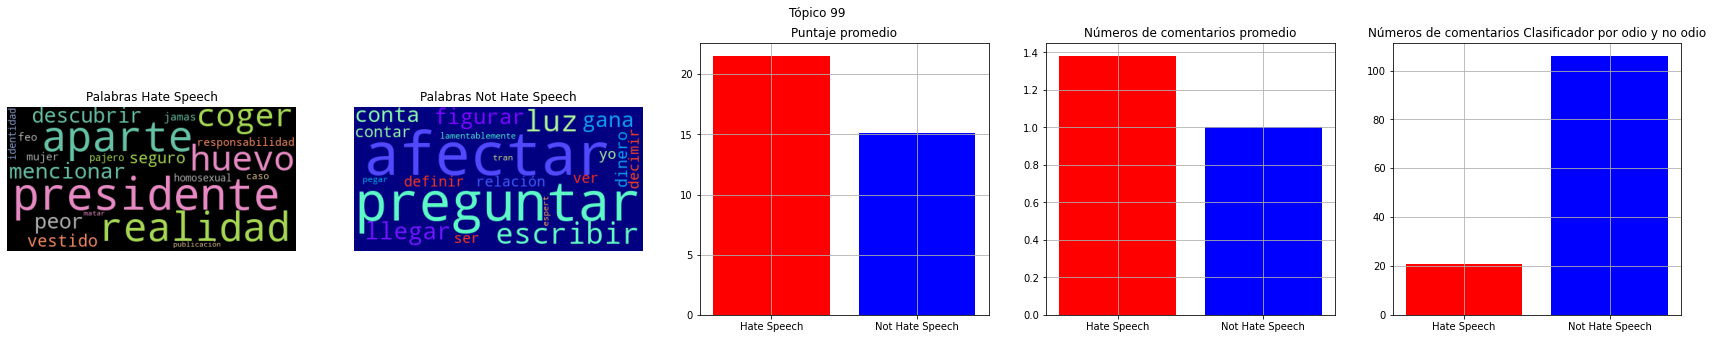

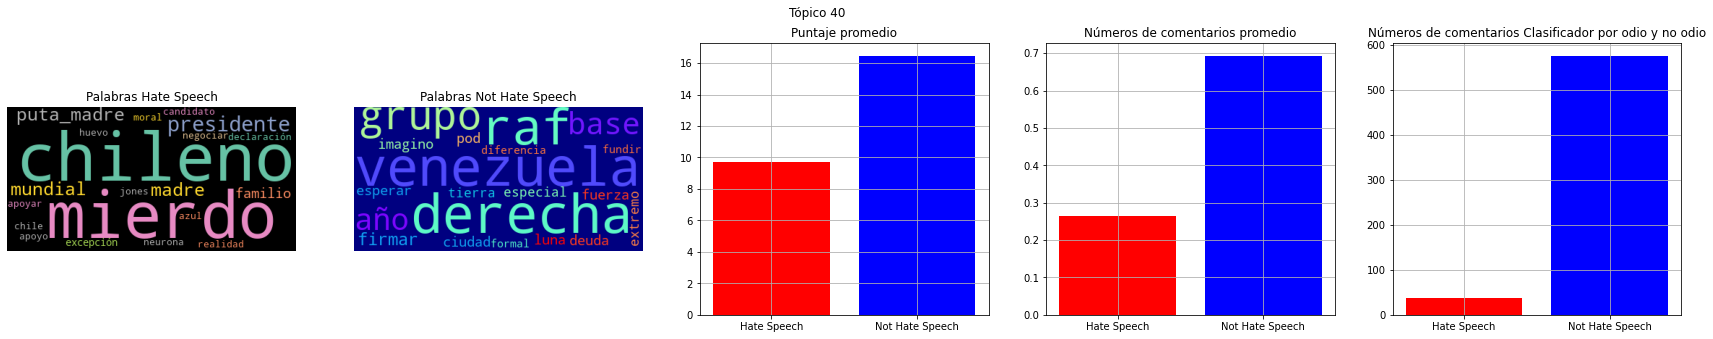

In [19]:
df_marks = plot_word_cloud([99,40], "pmi")

In [20]:
TEXT_FILE_READ_GENERO = 'docs/analisis/genero.csv'

analisis_manual_genero = pd.read_csv(TEXT_FILE_READ_GENERO)

count_total_hate_speech = 0
count_total_hate_manual = 0
count_total_agresivo_manual = 0

count_is_hate_manual_and_is_hate_model = 0
count_is_hate_manual_and_is_not_hate_model = 0
count_is_not_hate_manual_and_is_hate_model = 0

count_is_agresivo_manual_and_is_hate_model = 0
count_is_agresivo_manual_and_is_not_hate_model = 0
count_is_not_agresivo_manual_and_is_hate_model = 0

count_is_agresivo_or_hate_manual_and_is_hate_model = 0
count_is_agresivo_or_hate_manual_and_is_not_hate_model = 0
count_is_not_agresivo_or_hate_manual_and_is_hate_model = 0

for index, row in analisis_manual_genero.iterrows():
    is_agresivo_manual = row['agresivo_manual'] == 'Si'
    is_hate_manual = row['hate_manual'] == 'Si'
    is_hate_model = row['hate_speech'] == 'si'
    
    if is_agresivo_manual:
        count_total_agresivo_manual = count_total_agresivo_manual + 1

    if is_hate_manual:
        count_total_hate_manual = count_total_hate_manual + 1
        
    if is_hate_model:
        count_total_hate_speech = count_total_hate_speech + 1
        
    if is_hate_manual & is_hate_model:
        count_is_hate_manual_and_is_hate_model = count_is_hate_manual_and_is_hate_model + 1
        
    if is_hate_manual & is_hate_model != True:
        count_is_hate_manual_and_is_not_hate_model = count_is_hate_manual_and_is_not_hate_model + 1
        
    if is_hate_manual != True & is_hate_model:
        count_is_not_hate_manual_and_is_hate_model = count_is_not_hate_manual_and_is_hate_model + 1
        
    if is_agresivo_manual & is_hate_model:
        count_is_agresivo_manual_and_is_hate_model = count_is_agresivo_manual_and_is_hate_model + 1
        
    if is_agresivo_manual & is_hate_model != True:
        count_is_agresivo_manual_and_is_not_hate_model = count_is_agresivo_manual_and_is_not_hate_model + 1
        
    if is_agresivo_manual != True & is_hate_model:
        count_is_not_agresivo_manual_and_is_hate_model = count_is_not_agresivo_manual_and_is_hate_model + 1
    
    
    if (is_hate_manual | is_agresivo_manual) & is_hate_model:
        count_is_agresivo_or_hate_manual_and_is_hate_model = count_is_agresivo_or_hate_manual_and_is_hate_model + 1
        
    if (is_hate_manual | is_agresivo_manual) & is_hate_model != True:
        count_is_agresivo_or_hate_manual_and_is_not_hate_model = count_is_agresivo_or_hate_manual_and_is_not_hate_model + 1
        
    if (is_hate_manual | is_agresivo_manual) != True & is_hate_model:
        count_is_not_agresivo_or_hate_manual_and_is_hate_model = count_is_not_agresivo_or_hate_manual_and_is_hate_model + 1

print('Resultados')
print()
print('Total de comentarios detectados como discurso de odio por el modelo: ' + str(count_total_hate_speech))
print('Total de comentarios detectados como discurso de odio manualmente: ' + str(count_total_hate_manual))
print('Total de comentarios detectados como agresivos manualmente: ' + str(count_total_agresivo_manual))
print()
print('Comentarios detectados como discurso de odio por el modelo y manualmente: ' + str(count_is_hate_manual_and_is_hate_model))
print('Comentarios detectados como discurso de odio por el modelo y pero no manualmente: ' + str(count_is_not_hate_manual_and_is_hate_model))
print('Comentarios detectados como discurso de odio manualmente pero no por el modelo: ' + str(count_is_hate_manual_and_is_not_hate_model))
print()
print('Comentarios detectados como discurso de odio por el modelo y agresivos manualmente: ' + str(count_is_agresivo_manual_and_is_hate_model))
print('Comentarios detectados como discurso de odio por el modelo y pero no agresivos manualmente: ' + str(count_is_not_agresivo_manual_and_is_hate_model))
print('Comentarios detectados como agresivo manualmente pero no como discurso de odio por el modelo: ' + str(count_is_agresivo_manual_and_is_not_hate_model))
print()
print('Comentarios detectados como discurso de odio por el modelo y discurso de odio/agresivo manualmente: ' + str(count_is_agresivo_or_hate_manual_and_is_hate_model))
print('Comentarios detectados como discurso de odio por el modelo y pero no discurso de odio/agresivo manualmente: ' + str(count_is_not_agresivo_or_hate_manual_and_is_hate_model))
print('Comentarios detectados como agresivo o discurso de odio manualmente pero no como discurso de odio por el modelo: ' + str(count_is_agresivo_or_hate_manual_and_is_not_hate_model))

Resultados

Total de comentarios detectados como discurso de odio por el modelo: 21
Total de comentarios detectados como discurso de odio manualmente: 23
Total de comentarios detectados como agresivos manualmente: 23

Comentarios detectados como discurso de odio por el modelo y manualmente: 8
Comentarios detectados como discurso de odio por el modelo y pero no manualmente: 28
Comentarios detectados como discurso de odio manualmente pero no por el modelo: 119

Comentarios detectados como discurso de odio por el modelo y agresivos manualmente: 10
Comentarios detectados como discurso de odio por el modelo y pero no agresivos manualmente: 24
Comentarios detectados como agresivo manualmente pero no como discurso de odio por el modelo: 117

Comentarios detectados como discurso de odio por el modelo y discurso de odio/agresivo manualmente: 10
Comentarios detectados como discurso de odio por el modelo y pero no discurso de odio/agresivo manualmente: 28
Comentarios detectados como agresivo o di

In [21]:
TEXT_FILE_READ_GENERO = 'docs/analisis/genero.csv'

analisis_manual_genero = pd.read_csv(TEXT_FILE_READ_GENERO)

count_total_no_hate_speech = 0
count_total_no_hate_manual = 0
count_total_no_agresivo_manual = 0

count_is_not_hate_manual_and_is_not_hate_model = 0
count_is_not_hate_manual_and_is_hate_model = 0
count_is_hate_manual_and_is_not_hate_model = 0

count_is_not_agresivo_manual_and_is_not_hate_model = 0
count_is_not_agresivo_manual_and_is_hate_model = 0
count_is_agresivo_manual_and_is_not_hate_model = 0

count_is_not_agresivo_or_hate_manual_and_is_not_hate_model = 0
count_is_not_agresivo_or_hate_manual_and_is_hate_model = 0
count_is_agresivo_or_hate_manual_and_is_not_hate_model = 0

for index, row in analisis_manual_genero.iterrows():
    is_not_agresivo_manual = row['agresivo_manual'] == 'No'
    is_not_hate_manual = row['hate_manual'] == 'No'
    is_not_hate_model = row['hate_speech'] == 'no'
    
    if is_not_agresivo_manual:
        count_total_no_agresivo_manual = count_total_no_agresivo_manual + 1

    if is_not_hate_manual:
        count_total_no_hate_manual = count_total_no_hate_manual + 1
        
    if is_not_hate_model:
        count_total_no_hate_speech = count_total_no_hate_speech + 1
        
    if is_not_hate_manual & is_not_hate_model:
        count_is_not_hate_manual_and_is_not_hate_model = count_is_not_hate_manual_and_is_not_hate_model + 1
        
    if is_not_hate_manual & is_not_hate_model != True:
        count_is_not_hate_manual_and_is_hate_model = count_is_not_hate_manual_and_is_hate_model + 1
        
    if is_not_hate_manual != True & is_not_hate_model:
        count_is_hate_manual_and_is_not_hate_model = count_is_hate_manual_and_is_not_hate_model + 1
        
    if is_not_agresivo_manual & is_not_hate_model:
        count_is_not_agresivo_manual_and_is_not_hate_model = count_is_not_agresivo_manual_and_is_not_hate_model + 1
        
    if is_not_agresivo_manual & is_not_hate_model != True:
        count_is_not_agresivo_manual_and_is_hate_model = count_is_not_agresivo_manual_and_is_hate_model + 1
        
    if is_not_agresivo_manual != True & is_not_hate_model:
        count_is_agresivo_manual_and_is_not_hate_model = count_is_agresivo_manual_and_is_not_hate_model + 1
    
    
    if (is_not_hate_manual | is_not_agresivo_manual) & is_not_hate_model:
        count_is_not_agresivo_or_hate_manual_and_is_not_hate_model = count_is_not_agresivo_or_hate_manual_and_is_not_hate_model + 1
        
    if (is_not_hate_manual | is_not_agresivo_manual) & is_not_hate_model != True:
        count_is_not_agresivo_or_hate_manual_and_is_hate_model = count_is_not_agresivo_or_hate_manual_and_is_hate_model + 1
        
    if (is_not_hate_manual | is_not_agresivo_manual) != True & is_not_hate_model:
        count_is_agresivo_or_hate_manual_and_is_not_hate_model = count_is_agresivo_or_hate_manual_and_is_not_hate_model + 1
    
print('Resultados')
print()
print('Total de comentarios detectados como no discurso de odio por el modelo: ' + str(count_total_no_hate_speech))
print('Total de comentarios detectados como no discurso de odio manualmente: ' + str(count_total_no_hate_manual))
print('Total de comentarios detectados como no agresivos manualmente: ' + str(count_total_no_agresivo_manual))
print()
print('Comentarios detectados como no discurso de odio por el modelo y manualmente: ' + str(count_is_not_hate_manual_and_is_not_hate_model))
print('Comentarios detectados como no discurso de odio por el modelo y pero si manualmente: ' + str(count_is_hate_manual_and_is_not_hate_model))
print('Comentarios detectados como no discurso de odio manualmente pero si por el modelo: ' + str(count_is_not_hate_manual_and_is_hate_model))
print()
print('Comentarios detectados como no discurso de odio por el modelo y no agresivo manualmente: ' + str(count_is_not_agresivo_manual_and_is_not_hate_model))
print('Comentarios detectados como no discurso de odio por el modelo y pero si agresivos manualmente: ' + str(count_is_agresivo_manual_and_is_not_hate_model))
print('Comentarios detectados como no gresivo manualmente pero si como discurso de odio por el modelo: ' + str(count_is_not_agresivo_manual_and_is_not_hate_model))
print()
print('Comentarios detectados como no discurso de odio por el modelo y no discurso de odio/agresivo manualmente: ' + str(count_is_not_agresivo_or_hate_manual_and_is_not_hate_model))
print('Comentarios detectados como no discurso de odio por el modelo y pero si discurso de odio/agresivo manualmente: ' + str(count_is_agresivo_or_hate_manual_and_is_not_hate_model))
print('Comentarios detectados como no agresivo ni discurso de odio manualmente pero si como discurso de odio por el modelo: ' + str(count_is_not_agresivo_or_hate_manual_and_is_hate_model))

Resultados

Total de comentarios detectados como no discurso de odio por el modelo: 106
Total de comentarios detectados como no discurso de odio manualmente: 104
Total de comentarios detectados como no agresivos manualmente: 104

Comentarios detectados como no discurso de odio por el modelo y manualmente: 91
Comentarios detectados como no discurso de odio por el modelo y pero si manualmente: 28
Comentarios detectados como no discurso de odio manualmente pero si por el modelo: 36

Comentarios detectados como no discurso de odio por el modelo y no agresivo manualmente: 93
Comentarios detectados como no discurso de odio por el modelo y pero si agresivos manualmente: 24
Comentarios detectados como no gresivo manualmente pero si como discurso de odio por el modelo: 93

Comentarios detectados como no discurso de odio por el modelo y no discurso de odio/agresivo manualmente: 95
Comentarios detectados como no discurso de odio por el modelo y pero si discurso de odio/agresivo manualmente: 24
Co

In [22]:
df_marks.describe()

,topic,score_hate_speech,score_not_hate_speech,comms_num_hate_speech,comms_num_not_hate_speech
count,2.0000,2.000000,2.000000,2.000000,2.000000
mean,69.5000,15.617168,15.791732,0.822055,0.846354
std,41.7193,8.353253,0.932895,0.790400,0.217288
min,40.0000,9.710526,15.132075,0.263158,0.692708
25%,54.7500,12.663847,15.461904,0.542607,0.769531
50%,69.5000,15.617168,15.791732,0.822055,0.846354
75%,84.2500,18.570489,16.121561,1.101504,0.923177
max,99.0000,21.523810,16.451389,1.380952,1.000000


### Cherry picking

In [23]:

selected_cluster = 17

reddit_words_all = reddit[reddit["cluster"] == str([selected_cluster])]['lemma_tokens'].apply(literal_eval)
reddit_words_hate = reddit[(reddit["cluster"] == str([selected_cluster])) &
                      (reddit["hate_speech"]=="si")]['lemma_tokens'].apply(literal_eval)
bigram_finder = BigramCollocationFinder.from_documents(reddit_words_all)
trigram_finder = TrigramCollocationFinder.from_documents(reddit_words_all)
bigram_finder.apply_freq_filter(2)  # limitamos la cantidad mínima de palabras que deben aparecer
trigram_finder.apply_freq_filter(2)

In [24]:
word_pmis = {}
hate_speech = "si"
total_msgs = len(reddit['body_preprocessing']) - reddit['body_preprocessing'].isnull().value_counts()[1]
minimum_word_occurrences = 10

reddit_words_hate = reddit[(reddit["cluster"] == str([selected_cluster])) &
                  (reddit["hate_speech"]=="si")]['lemma_tokens'].apply(literal_eval)
reddit_words_counter_hate = Counter(sum(list(reddit_words_hate),[]))

for word in reddit_words_counter_hate:
    
    try:
        p_non_hate_msg_without_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
        p_hate_msg_without_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
        p_non_hate_msg_with_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
        p_hate_msg_with_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
    except:
        continue

    if (p_non_hate_msg_with_word + p_hate_msg_with_word)*total_msgs >= minimum_word_occurrences:

        if hate_speech == "si":
            word_pmis[word] = np.log2(p_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
        elif hate_speech == "no":
            word_pmis[word] = np.log2(p_non_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
        else:
            raise ValueError("Se pasó un argumento desconocido para obtener pmi")

In [25]:
word_pmis_sorted = sorted(word_pmis.items(),key=lambda x:x[1], reverse=True)
word_pmis_sorted[:30]

[('pario', 2.7433825929662747),
 ('mierdo', 2.6806468376183124),
 ('mierda', 2.589348964293854),
 ('mierdar', 2.5665048308821956),
 ('puto', 2.470364098559859),
 ('simio', 2.46327467377354),
 ('hdp', 2.400990395519197),
 ('presidente', 2.3910808490353936),
 ('puta_madre', 2.3897456383515743),
 ('gordo', 2.374148783300556),
 ('madre', 2.3497187444799983),
 ('concha', 2.212867876267495),
 ('cagón', 2.1584200922451187),
 ('petiso', 2.0064169988000686),
 ('culo', 2.0023008903278368),
 ('ponetir', 1.8364919973577565),
 ('realidad', 1.8173831744100517),
 ('huevo', 1.7999661213326423),
 ('viejo', 1.7207811640291422),
 ('naaa', 1.5209901716298269),
 ('falso', 1.4632746737735394),
 ('descartar', 1.4214544980789123),
 ('jubilado', 1.4214544980789123),
 ('aval', 1.4214544980789123),
 ('serial', 1.4214544980789123),
 ('apreciar', 1.4214544980789123),
 ('edificio', 1.4214544980789123),
 ('pelotudo', 1.3573241606591968),
 ('paso', 1.3261475379831846),
 ('ignorante', 1.3104231856901685)]

In [26]:
word2vec_model = Word2Vec.load('docs/models/word2vec.model')
fasttext_model = FastText.load('docs/models/fasttext.model')

with open('docs/models/word2vec_kmeans.model', 'rb') as f:
    word2vec_kmeans = pickle.load(f)
    
with open('docs/models/fasttext_kmeans.model', 'rb') as f:
    fasttext_kmeans = pickle.load(f)

In [27]:
ver_palabras_asociadas([word_pmis_sorted[i][0] for i in range(10)], word2vec_model, word2vec_kmeans)

Palabra: pario
Clúster: [116]
Términos cercanos: [('pobretonto', 0.7889789938926697), ('palmó', 0.7833644151687622), ('ramen', 0.7613103985786438), ('escoger', 0.7466124296188354), ('comper', 0.7394694089889526), ('carpinchistico', 0.7357847094535828), ('kjjjjjjjjjjj', 0.7342244386672974), ('podrida', 0.7176601886749268), ('anfeta', 0.6871074438095093), ('refuta', 0.6751058101654053)] 

Palabra: mierdo
Clúster: [17]
Términos cercanos: [('nefasto', 0.4003210961818695), ('mierda', 0.3582106828689575), ('cabeza', 0.3461567163467407), ('imagina', 0.3386628031730652), ('lamentablemente', 0.33285757899284363), ('culpar', 0.3291051685810089), ('año', 0.32903388142585754), ('vuelvepartido', 0.3284968435764313), ('democracia', 0.3254987299442291), ('pidan', 0.3190957009792328)] 

Palabra: mierda
Clúster: [17]
Términos cercanos: [('banca', 0.4168201982975006), ('ganaba', 0.3647879660129547), ('mierdo', 0.35821065306663513), ('economía', 0.355868399143219), ('bajon', 0.3554363548755646), ('larret

In [28]:
ver_palabras_asociadas([word_pmis_sorted[i][0] for i in range(10)], fasttext_model, fasttext_kmeans)

Palabra: pario
Clúster: [91]
Términos cercanos: [('ario', 0.8494244813919067), ('fario', 0.8485210537910461), ('ovario', 0.8480972647666931), ('pasario', 0.8433429002761841), ('partidario', 0.830518901348114), ('lario', 0.82918781042099), ('hario', 0.8288808465003967), ('acuario', 0.8261533379554749), ('tario', 0.820868730545044), ('becario', 0.8183266520500183)] 

Palabra: mierdo
Clúster: [59]
Términos cercanos: [('mierdx', 0.8845037817955017), ('mierd', 0.8771346807479858), ('pierdo', 0.8431238532066345), ('m\\*erdo', 0.7954245209693909), ('mierdelli', 0.7953404784202576), ('mierda', 0.7920945882797241), ('miercol', 0.7763689756393433), ('mierdar', 0.7339200377464294), ('mier', 0.7313688397407532), ('lerdo', 0.7219255566596985)] 

Palabra: mierda
Clúster: [59]
Términos cercanos: [('mierdx', 0.9396186470985413), ('mierd', 0.9311040043830872), ('mierdelli', 0.8570907115936279), ('mierdaaaa', 0.8506362438201904), ('mierdar', 0.8308877944946289), ('pierda', 0.8220406174659729), ('m*erda'